In [768]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [769]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [770]:
print(test["date"].max())
test["date"].describe()

2019-12-31


count          98550
unique          1095
top       2017-01-01
freq              90
Name: date, dtype: object

In [771]:
train["date"] = pd.to_datetime(train["date"])
train.head()

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [772]:
mask = (train['country'] == 'Canada') & (train['product'] == 'Kaggle Tiers') & (train['store'] == 'Discount Stickers')
train[mask]

,date,country,store,product,num_sold
id,,,,,
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
92,2010-01-02,Canada,Discount Stickers,Kaggle Tiers,854.0
182,2010-01-03,Canada,Discount Stickers,Kaggle Tiers,839.0
272,2010-01-04,Canada,Discount Stickers,Kaggle Tiers,609.0
362,2010-01-05,Canada,Discount Stickers,Kaggle Tiers,640.0
...,...,...,...,...,...
229682,2016-12-27,Canada,Discount Stickers,Kaggle Tiers,577.0
229772,2016-12-28,Canada,Discount Stickers,Kaggle Tiers,601.0
229862,2016-12-29,Canada,Discount Stickers,Kaggle Tiers,687.0


In [773]:
#log transformed target + MAE (to get the nearest possible to MAPE metric)
#use GroupKFold to keep the order in the time-series

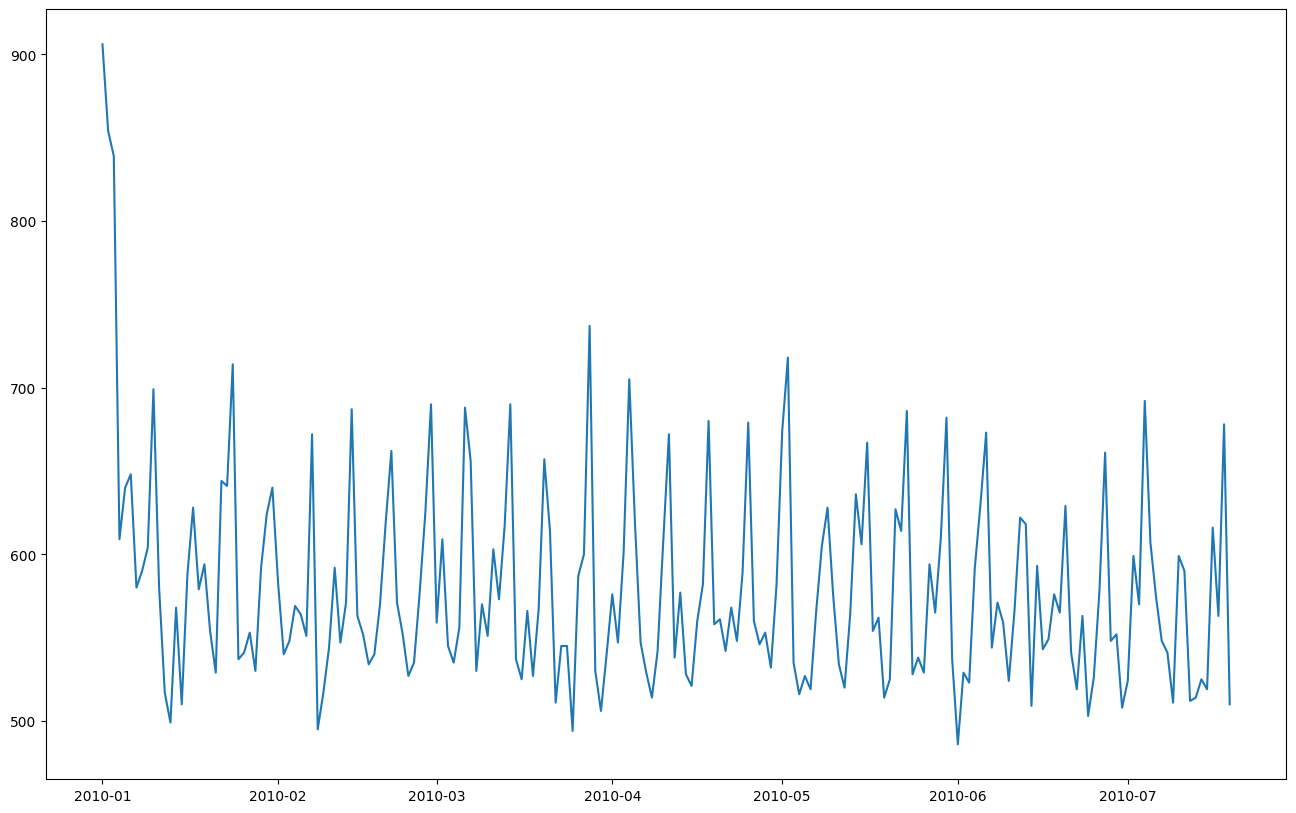

In [774]:
plt.figure(figsize=(16,10))
plt.plot(train[mask]['date'][:200], train[mask]['num_sold'][:200])

In [775]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [776]:
train.rename(columns={"num_sold" : "target"}, inplace=True)
train.dropna(axis=0, how="any", subset="target", inplace=True)
train["target"] = np.log1p(train["target"])


In [777]:
train, valid = train_test_split(train, train_size=0.79905, shuffle=False)
#0.798985 to conserve the 90 values for each date
#0.79905 to keep the same date together

In [778]:
(train["target"] == 0).sum()

0

In [779]:
train.isna().sum() #visualiser si y a pas des liens entre le NA, et qqch

date       0
country    0
store      0
product    0
target     0
dtype: int64

# TREND PREDICTION

In [780]:
# time step

In [781]:
train['time_step'] = (train['date'] - train['date'].min()).dt.days
train['time_step_sqrd'] = train['time_step']**2
train['time_step_cube'] = train['time_step']**3

In [782]:
# lags and ma

In [783]:
len(train.drop_duplicates(subset="date")) #avec mon lag de 400, je perds donc 20% de mon train

2046

In [784]:
train['lag_30'] = train.groupby(['country', 'store', 'product'])['target'].shift(30)
train['lag_60'] = train.groupby(['country', 'store', 'product'])['target'].shift(60)
train['lag_120'] = train.groupby(['country', 'store', 'product'])['target'].shift(120)
train['lag_180'] = train.groupby(['country', 'store', 'product'])['target'].shift(180)
train['lag_240'] = train.groupby(['country', 'store', 'product'])['target'].shift(240)
train['lag_300'] = train.groupby(['country', 'store', 'product'])['target'].shift(300)
train['lag_400'] = train.groupby(['country', 'store', 'product'])['target'].shift(400)

train['rolling_mean_30'] = train.groupby(['country', 'store', 'product'])['target'].rolling(30).mean().reset_index(level=[0, 1, 2], drop=True)
train['rolling_mean_60'] = train.groupby(['country', 'store', 'product'])['target'].rolling(60).mean().reset_index(level=[0, 1, 2], drop=True)
train['rolling_mean_150'] = train.groupby(['country', 'store', 'product'])['target'].rolling(150).mean().reset_index(level=[0, 1, 2], drop=True)
train['rolling_mean_300'] = train.groupby(['country', 'store', 'product'])['target'].rolling(300).mean().reset_index(level=[0, 1, 2], drop=True)

In [785]:
train.dropna(how="any", inplace=True)
print(len(train))
print(len(train.drop_duplicates(subset="date")))

141597
1646


In [92]:
# encoding (target, frequency, one-hot)